In [2]:
# importing modules
import dvc.api
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import mlflow
from IPython.display import Markdown, display, Image
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
# importing scripts
import sys
sys.path.insert(0,'../scripts/')
from data_manipulation import DataManipulator
from plot import exploration
from lstm_model import ltsm_time

### Importing Unlabeled data from DVC

In [ ]:
#Importing the collected Data
path = 'data/train_store.csv'
repo = 'https://github.com/HenokD11/SalesPrediction'
rev = 'v3-scaled'
data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
scaled = pd.read_csv(data_url)

In [6]:
scaled.head()

,DayOfWeek,WeekDay,Year,Month,Season,Day,MonthTiming,Sales,Customers,Open,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesPerCustomer,CompetitionOpenSince
0,0.501484,0.630672,1.502077,0.346724,0.389712,1.740766,1.205894,-0.063134,-0.067027,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.093996,0.595717
1,0.000831,0.630672,1.502077,0.346724,0.389712,1.626969,1.205894,-0.136239,-0.092863,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.207208,0.595717
2,-0.499823,0.630672,1.502077,0.346724,0.389712,1.513173,1.205894,-0.207840,-0.158887,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.227101,0.595717
3,-1.000476,0.630672,1.502077,0.346724,0.389712,1.399377,1.205894,-0.138946,-0.052674,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.303632,0.595717
4,-1.501129,0.630672,1.502077,0.346724,0.389712,1.285581,1.205894,0.189274,0.096598,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,0.097227,0.595717


In [7]:
train = pd.read_csv('../data/train.csv')
train = train[['Date','Sales']]
#train = train.groupby('Date').agg({'Sales':'mean'})

In [8]:
train.head()

,Date,Sales
0,2015-07-31,5263
1,2015-07-31,6064
2,2015-07-31,8314
3,2015-07-31,13995
4,2015-07-31,4822


In [9]:
df = train
df

,Date,Sales
0,2015-07-31,5263
1,2015-07-31,6064
2,2015-07-31,8314
3,2015-07-31,13995
4,2015-07-31,4822
...,...,...
1017204,2013-01-01,0
1017205,2013-01-01,0
1017206,2013-01-01,0
1017207,2013-01-01,0


In [10]:
df.sort_values(by='Date', ascending = True, inplace=True)
df.head()

,Date,Sales
1017208,2013-01-01,0
1016473,2013-01-01,0
1016472,2013-01-01,0
1016471,2013-01-01,0
1016470,2013-01-01,0


In [11]:
df2 = df[['Date', 'Sales']]
df2.head()

,Date,Sales
1017208,2013-01-01,0
1016473,2013-01-01,0
1016472,2013-01-01,0
1016471,2013-01-01,0
1016470,2013-01-01,0


In [12]:
df2.Date = pd.to_datetime(df2.Date)

In [13]:
df2 = df2[df2['Sales'] > 0.0]

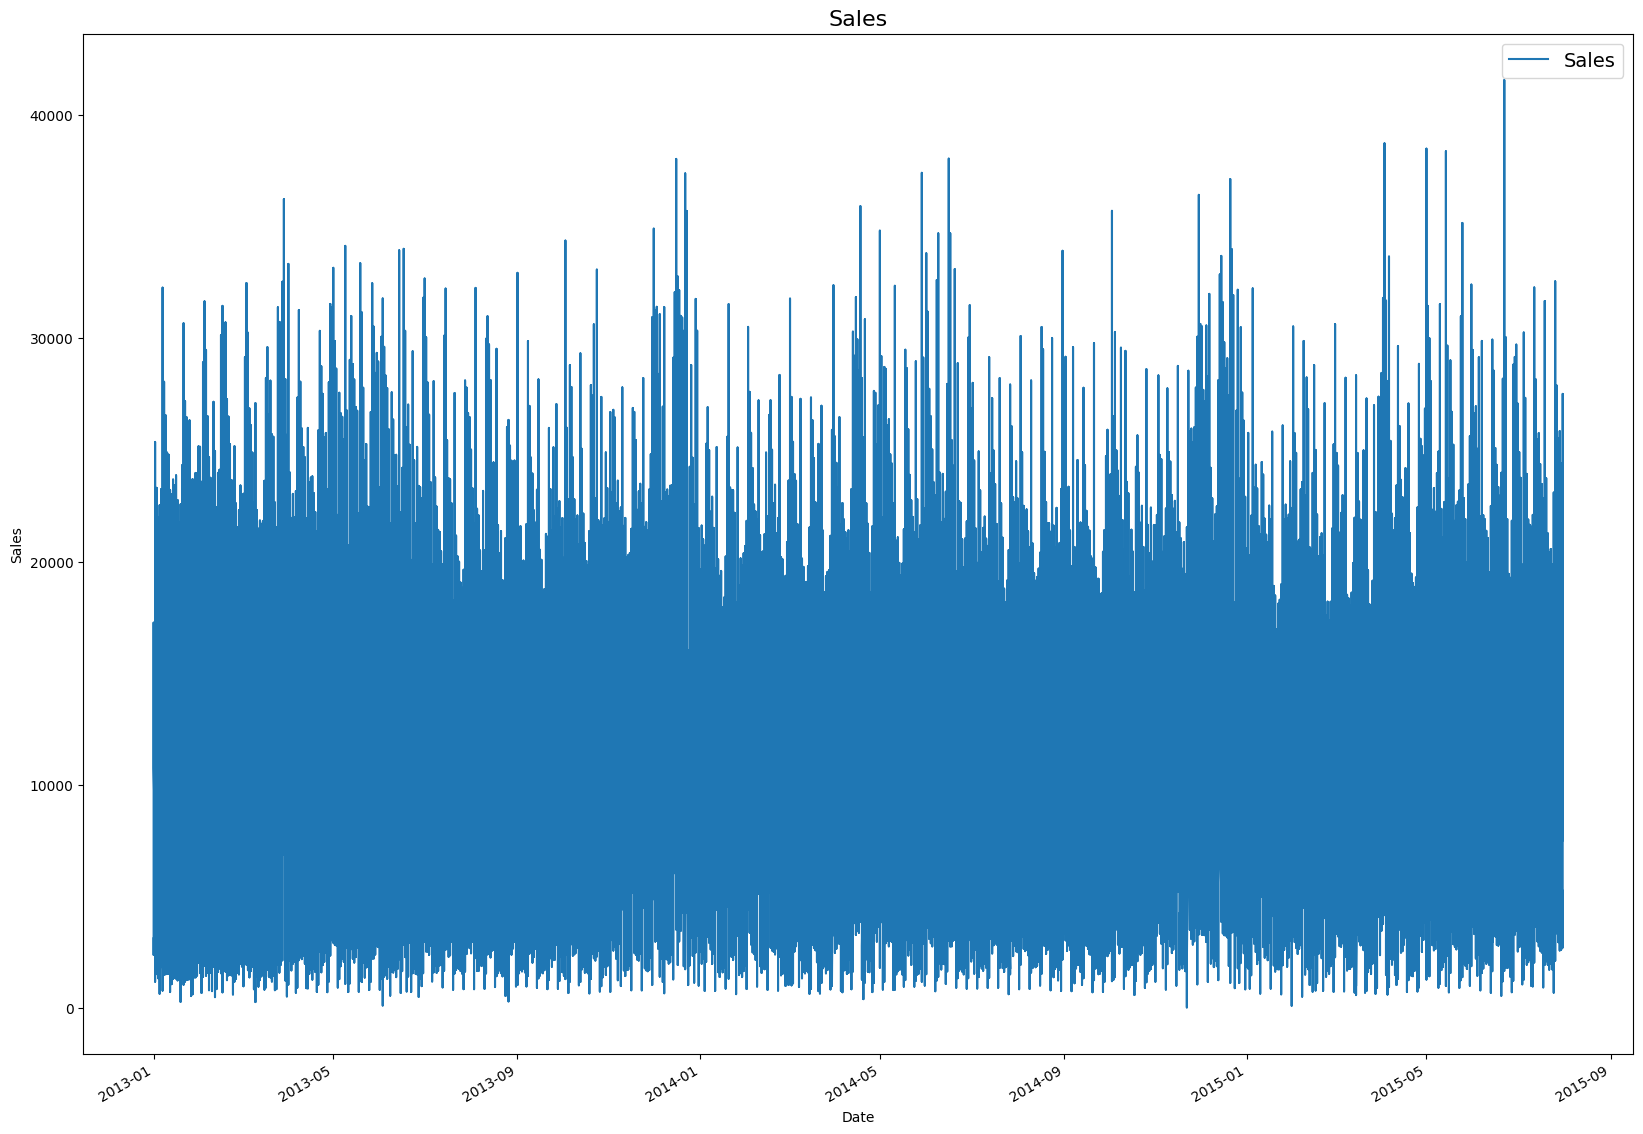

In [14]:
import matplotlib.pyplot as plt
df2.plot(x='Date', figsize=(20, 15))
plt.ylabel("Sales")
plt.title("Sales", fontsize=16)
plt.legend(fontsize=14);
plt.show()

In [15]:
train_size = int(len(df2) * 0.70)
test_size = len(df2) - train_size
train, testt = df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]
print(train.shape, testt.shape)

(591036, 2) (253302, 2)


In [16]:
test_size = int(len(testt) * 0.50)
val_size = len(testt) - test_size
test, val = testt.iloc[0:test_size], testt.iloc[test_size:len(testt)]
print(val.shape, test.shape)

(126651, 2) (126651, 2)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Sales']])

train['Sales'] = scaler.transform(train[['Sales']])
test['Sales'] = scaler.transform(test[['Sales']])
val['Sales'] = scaler.transform(val[['Sales']])

In [18]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

# X_train, y_train = create_sequences(updated_df_drop[['Close_scaled']], updated_df_drop['Close_scaled'])


X_train, y_train = create_sequences(train[['Sales']], train['Sales'])
X_test, y_test = create_sequences(test[['Sales']], test['Sales'])
X_val, y_val = create_sequences(val[['Sales']], val['Sales'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')
print(f'Testing shape: {X_val.shape}')

print(f'Testing shape: {y_train.shape}')
print(f'Testing shape: {y_test.shape}')
print(f'Testing shape: {y_val.shape}')

Training shape: (591006, 30, 1)
Testing shape: (126621, 30, 1)
Testing shape: (126621, 30, 1)
Testing shape: (591006,)
Testing shape: (126621,)
Testing shape: (126621,)


In [19]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))

model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, decay=0.01), loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [24]:
history = model.fit(X_train, y_train, epochs=3, batch_size=1024, validation_data=(X_val, y_val),
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')], shuffle=False)

Epoch 1/3
578/578 [==============================] - ETA: 7:06 - loss: 0.599 - ETA: 6:28 - loss: 0.575 - ETA: 6:32 - loss: 0.563 - ETA: 6:30 - loss: 0.577 - ETA: 6:27 - loss: 0.676 - ETA: 6:26 - loss: 0.702 - ETA: 6:39 - loss: 0.698 - ETA: 6:58 - loss: 0.687 - ETA: 7:15 - loss: 0.681 - ETA: 7:22 - loss: 0.681 - ETA: 7:27 - loss: 0.676 - ETA: 7:28 - loss: 0.660 - ETA: 7:28 - loss: 0.646 - ETA: 7:29 - loss: 0.633 - ETA: 7:34 - loss: 0.623 - ETA: 7:39 - loss: 0.616 - ETA: 7:42 - loss: 0.616 - ETA: 7:51 - loss: 0.627 - ETA: 7:53 - loss: 0.631 - ETA: 7:55 - loss: 0.632 - ETA: 7:56 - loss: 0.630 - ETA: 7:58 - loss: 0.629 - ETA: 7:59 - loss: 0.631 - ETA: 7:58 - loss: 0.630 - ETA: 7:58 - loss: 0.625 - ETA: 7:58 - loss: 0.619 - ETA: 7:58 - loss: 0.614 - ETA: 7:58 - loss: 0.613 - ETA: 7:59 - loss: 0.613 - ETA: 7:59 - loss: 0.616 - ETA: 7:58 - loss: 0.628 - ETA: 7:58 - loss: 0.634 - ETA: 7:58 - loss: 0.636 - ETA: 7:59 - loss: 0.636 - ETA: 7:59 - loss: 0.637 - ETA: 7:58 - loss: 0.637 - ETA: 7:59 -

### Scale sales

In [74]:
manu = DataManipulator(train)

In [75]:
# Using StandardScaler to standardize the all columns
scale_list = train.columns.to_list()
manu.standardize_columns(scale_list)

,Date,Sales
1016447,-1.718061,-1.202316
1016429,-1.718061,-1.442631
1016606,-1.718061,-1.362851
1016588,-1.718061,-1.210782
1016624,-1.718061,-1.277862
...,...,...
305598,1.797891,0.331403
305599,1.797891,0.197243
305625,1.797891,-0.505792
305624,1.797891,-1.250509


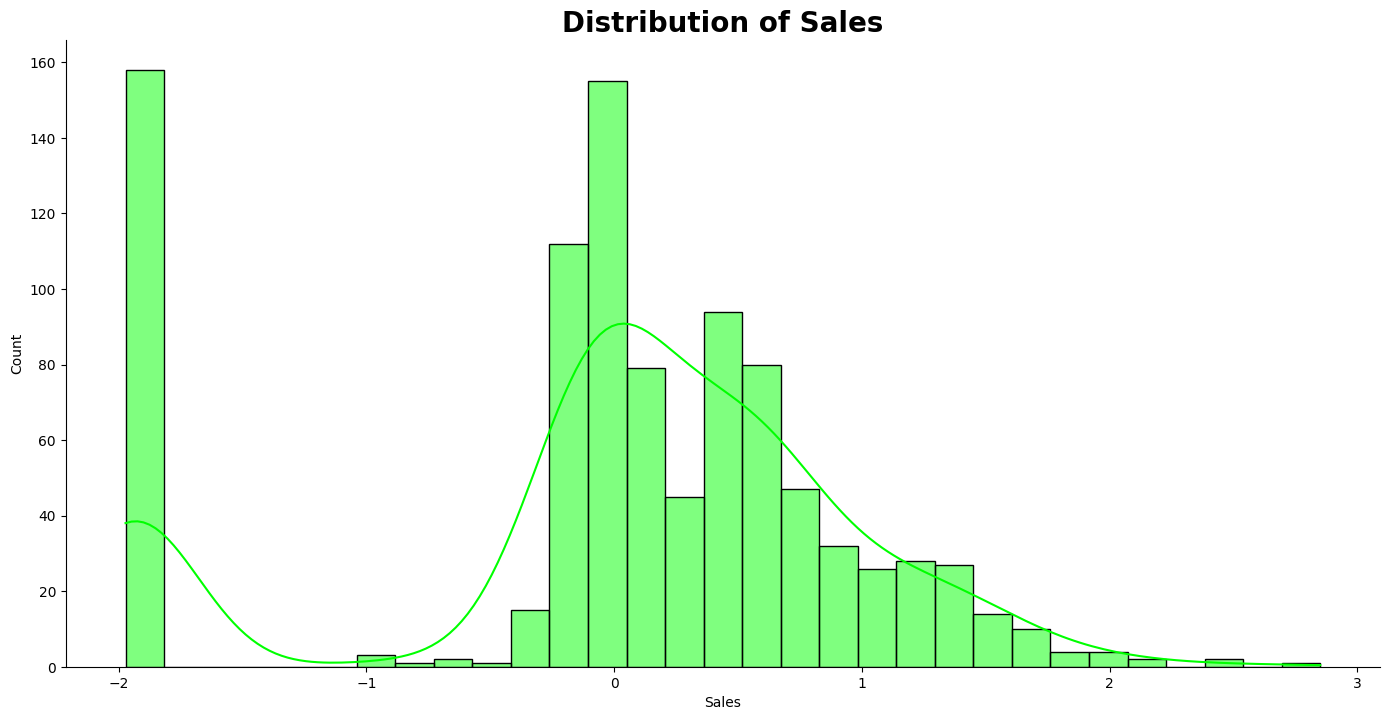

In [53]:
exploration.plot_hist(train, 'Sales', 'lime') 

In [77]:
train["Sales"] = train["Sales"].astype("float")

In [76]:
train["Sales"].isna().any().sum()

0

In [20]:
SIZE = len(train["Sales"])
WINDOW_SIZE = 49
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 20

t = ltsm_time(WINDOW_SIZE, BATCH_SIZE, train)

In [21]:
model1, his = t.train(EPOCHS)

ValueError: I/O operation on closed file